In [1]:
model_name = 'diffusion_model'

In [2]:
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import Callback
import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm

In [3]:
import random

seed = 42

# Python's built-in random library
random.seed(seed)

# Scikit-learn (only affects some parts of scikit-learn)
from sklearn.utils import check_random_state
check_random_state(seed)

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [4]:
img_rows = 168
img_cols = 168
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

In [5]:
# Set path for data source
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/diffusion_model/")

from diffusion_utilities import *

Mounted at /content/gdrive


In [6]:
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

In [7]:
# Set the path to the folder containing saved files
load_path = "./preprocessed_data_168x168_2years"

# Load saved NumPy arrays
X_train = np.load(os.path.join(load_path, 'X_train.npy'))
X_test = np.load(os.path.join(load_path, 'X_test.npy'))
y_train = np.load(os.path.join(load_path, 'y_train.npy'))
y_test = np.load(os.path.join(load_path, 'y_test.npy'))

# Load saved Pandas DataFrames
train_data = pd.read_pickle(os.path.join(load_path, 'train_data.pkl'))
test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
metadata = pd.read_pickle(os.path.join(load_path, 'metadata.pkl'))
metadata_original = pd.read_pickle(os.path.join(load_path, 'metadata_original.pkl'))

In [8]:
def merge_dummified_columns(df, dummified_columns, new_column_name):
    """
    Merges dummified columns into a single column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dummified columns.
        dummified_columns (list): A list of the names of the dummified columns.
        new_column_name (str): The name of the new column to create.

    Returns:
        pd.DataFrame: The DataFrame with the dummified columns merged into a single new column.
    """
    # Create a new column containing the column name where the value is 1 for each row
    df[new_column_name] = df[dummified_columns].idxmax(axis=1)

    # Drop the dummified columns
    df.drop(dummified_columns, axis=1, inplace=True)

    return df

test_metadata = metadata_original.loc[test_data.columns]

test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['chilledwater', 'electricity', 'gas', 'hotwater', 'steam'],
                     new_column_name='meter_type')
test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['Education', 'Entertainment/public assembly', 'Lodging/residential', 'Office', 'Public services'],
                     new_column_name='building_type')

test_metadata


,lat,lng,year,meter_type,building_type
electricity_Lamb_office_Caitlin_2016,51.497838,-3.186246,2016,electricity,Office
electricity_Rat_public_Kelle_2016,38.903504,-77.005349,2016,electricity,Public services
electricity_Rat_assembly_Ezequiel_2016,38.903504,-77.005349,2016,electricity,Entertainment/public assembly
electricity_Bear_assembly_Roxy_2016,37.871903,-122.260729,2016,electricity,Entertainment/public assembly
gas_Shrew_office_Rose_2017,51.499840,-0.124663,2017,gas,Office
...,...,...,...,...,...
steam_Moose_education_Omar_2016,45.421500,-75.697200,2016,steam,Education
electricity_Rat_public_Chrissy_2017,38.903504,-77.005349,2017,electricity,Public services
electricity_Hog_office_Merilyn_2016,44.978782,-93.255398,2016,electricity,Office
steam_Bull_assembly_Amalia_2016,30.267200,-97.743100,2016,steam,Entertainment/public assembly


In [9]:
model_path = "./weights_168x168"

# List all files in the directory
all_files = os.listdir(model_path)

# Filter files that contain 'model'
model_files = [file for file in all_files if model_name in file]

for model_file in model_files:
  print(model_file)
  #loaded_model = load_model(os.path.join(model_path, model_files[-1]))

diffusion_model_25.pth
diffusion_model_50.pth
diffusion_model_75.pth
diffusion_model_100.pth
diffusion_model_125.pth
diffusion_model_150.pth
diffusion_model_175.pth
diffusion_model_200.pth
diffusion_model_225.pth
diffusion_model_250.pth
diffusion_model_275.pth
diffusion_model_300.pth
diffusion_model_325.pth
diffusion_model_350.pth
diffusion_model_375.pth
diffusion_model_400.pth
diffusion_model_0.pth
diffusion_model_425.pth
diffusion_model_450.pth
diffusion_model_475.pth
diffusion_model_500.pth
diffusion_model_525.pth
diffusion_model_550.pth
diffusion_model_575.pth
diffusion_model_600.pth
diffusion_model_625.pth
diffusion_model_650.pth
diffusion_model_675.pth
diffusion_model_700.pth
diffusion_model_725.pth
diffusion_model_750.pth
diffusion_model_775.pth
diffusion_model_800.pth
diffusion_model_825.pth
diffusion_model_850.pth
diffusion_model_875.pth
diffusion_model_900.pth
diffusion_model_925.pth
diffusion_model_950.pth
diffusion_model_975.pth
diffusion_model_999.pth
diffusion_model_1000.

In [10]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = int(y_train.shape[1]) # context vector is of size 7
height = 168 # 16x16 image
save_dir = './weights_168x168/'

# training hyperparameters
batch_size = 10 #100
n_epoch = 500
lrate=1e-3

In [11]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [12]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, channels, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [13]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [14]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=64):  # cfeat - context features
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        # Adding third down-sampling layer
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)
        self.down3 = UnetDown(2 * n_feat, 4 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d((self.h//8)), nn.GELU())

        self.timeembed1 = EmbedFC(1, 4 * n_feat)
        self.timeembed2 = EmbedFC(1, 2 * n_feat)
        self.timeembed3 = EmbedFC(1, 1 * n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 4 * n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 2 * n_feat)
        self.contextembed3 = EmbedFC(n_cfeat, 1 * n_feat)

        # Adding third up-sampling layer
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(4 * n_feat, 4 * n_feat, self.h//8, self.h//8),
            nn.GroupNorm(8, 4 * n_feat),
            nn.ReLU(),
        )
        self.up1 = UnetUp(8 * n_feat, 2 * n_feat)
        self.up2 = UnetUp(4 * n_feat, 1 * n_feat)
        self.up3 = UnetUp(2 * n_feat, n_feat)  # New added layer

        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, t, c=None):
        x = self.init_conv(x)

        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)

        hiddenvec = self.to_vec(down3)

        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 4, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 4, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat * 2, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat * 2, 1, 1)
        cemb3 = self.contextembed3(c).view(-1, self.n_feat, 1, 1)
        temb3 = self.timeembed3(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1 * up1 + temb1, down3)
        up3 = self.up2(cemb2 * up2 + temb2, down2)
        up4 = self.up3(cemb3 * up3 + temb3, down1)

        out = self.out(torch.cat((up4, x), 1))
        return out


In [15]:
# construct model
nn_model = ContextUnet(in_channels=channels, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [16]:
loaded_model = 'diffusion_model_1000.pth'
loaded_model

'diffusion_model_1000.pth'

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
nn_model.load_state_dict(torch.load(os.path.join(model_path, loaded_model), map_location=device))

<All keys matched successfully>

In [18]:
# Function to display images
def display_images(images, title):
    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:43<10:21, 103.57s/it]

 29%|██▊       | 2/7 [03:19<08:15, 99.16s/it] 

 43%|████▎     | 3/7 [04:55<06:31, 97.77s/it]

 57%|█████▋    | 4/7 [06:31<04:51, 97.12s/it]

 71%|███████▏  | 5/7 [08:07<03:13, 96.75s/it]

 86%|████████▌ | 6/7 [09:44<01:36, 96.53s/it]

100%|██████████| 7/7 [11:13<00:00, 96.21s/it]


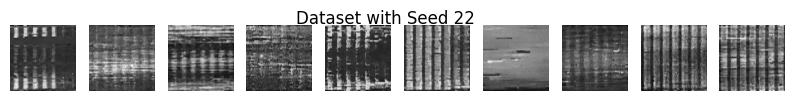

In [19]:
# Create a directory to save the generated image datasets
model_path = "./generation/" + model_name + "_168x168"
if not os.path.exists(model_path):
    os.makedirs(model_path)

labels_to_condition = y_test  # Assuming you've already prepared y_test

chunk_size = 130
num_chunks = (len(labels_to_condition) + chunk_size - 1) // chunk_size  # This computes the ceil of division

# Loop to create 30 different datasets
for i in range(22, 23):
    np.random.seed(i)  # Set the random seed

    all_generated_images = []  # List to store all generated images across chunks

    for idx in tqdm(range(num_chunks)):
        start_idx = idx * chunk_size
        end_idx = min((idx + 1) * chunk_size, len(labels_to_condition))
        current_chunk = labels_to_condition[start_idx:end_idx]

        np.random.seed(idx)  # Set the random seed for each chunk

        ground_truth = torch.tensor(X_test[start_idx:end_idx]).float().to(device)
        ctx = torch.tensor(current_chunk).float().to(device)
        input_tensor, _ = sample_ddpm_context(ctx.shape[0], ctx)

        # Check if the tensor is on GPU
        if input_tensor.is_cuda:
            input_tensor = input_tensor.cpu()

        # Convert to NumPy array
        generated_images = input_tensor.numpy()
        generated_images = np.transpose(generated_images, (0, 2, 3, 1))

        # Rescale image pixel values to [0, 1]
        generated_images = 0.5 * generated_images + 0.5
        #display_images(generated_images, title=f"Dataset with Seed {i}")

        all_generated_images.append(generated_images)  # Add the generated images of this chunk to the list

    # Concatenate all the generated images
    all_generated_images = np.concatenate(all_generated_images, axis=0)

    # Show the first 10 images of the generated dataset
    display_images(all_generated_images, title=f"Dataset with Seed {i}")

    # Save the dataset
    np.save(os.path.join(model_path, f"generated_images_seed_{i}.npy"), all_generated_images)

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:43<10:21, 103.58s/it]

 29%|██▊       | 2/7 [03:18<08:13, 98.73s/it] 

 43%|████▎     | 3/7 [04:54<06:28, 97.17s/it]

 57%|█████▋    | 4/7 [06:29<04:49, 96.44s/it]

 71%|███████▏  | 5/7 [08:04<03:12, 96.03s/it]

 86%|████████▌ | 6/7 [09:40<01:35, 95.79s/it]

100%|██████████| 7/7 [11:08<00:00, 95.56s/it]


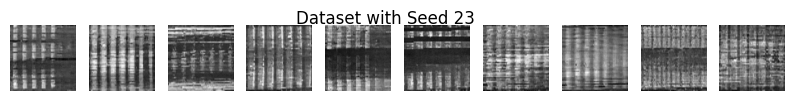

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:31, 95.30s/it]

 29%|██▊       | 2/7 [03:10<07:56, 95.30s/it]

 43%|████▎     | 3/7 [04:45<06:21, 95.30s/it]

 57%|█████▋    | 4/7 [06:21<04:45, 95.31s/it]

 71%|███████▏  | 5/7 [07:56<03:10, 95.31s/it]

 86%|████████▌ | 6/7 [09:31<01:35, 95.32s/it]

100%|██████████| 7/7 [11:00<00:00, 94.37s/it]


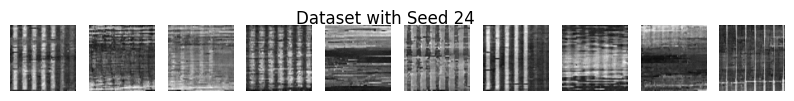

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:31, 95.30s/it]

 29%|██▊       | 2/7 [03:10<07:56, 95.30s/it]

 43%|████▎     | 3/7 [04:45<06:21, 95.30s/it]

 57%|█████▋    | 4/7 [06:21<04:45, 95.30s/it]

 71%|███████▏  | 5/7 [07:56<03:10, 95.30s/it]

 86%|████████▌ | 6/7 [09:31<01:35, 95.31s/it]

100%|██████████| 7/7 [11:00<00:00, 94.37s/it]


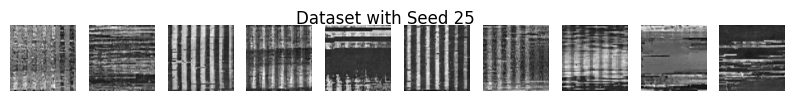

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:31, 95.30s/it]

 29%|██▊       | 2/7 [03:10<07:56, 95.30s/it]

 43%|████▎     | 3/7 [04:45<06:21, 95.30s/it]

 57%|█████▋    | 4/7 [06:21<04:45, 95.31s/it]

 71%|███████▏  | 5/7 [07:56<03:10, 95.30s/it]

 86%|████████▌ | 6/7 [09:31<01:35, 95.31s/it]

100%|██████████| 7/7 [11:00<00:00, 94.37s/it]


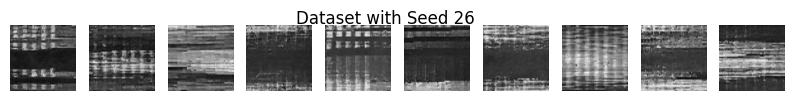

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:31, 95.31s/it]

 29%|██▊       | 2/7 [03:10<07:56, 95.30s/it]

 43%|████▎     | 3/7 [04:45<06:21, 95.29s/it]

 57%|█████▋    | 4/7 [06:21<04:45, 95.29s/it]

 71%|███████▏  | 5/7 [07:56<03:10, 95.31s/it]

 86%|████████▌ | 6/7 [09:31<01:35, 95.30s/it]

100%|██████████| 7/7 [11:00<00:00, 94.37s/it]


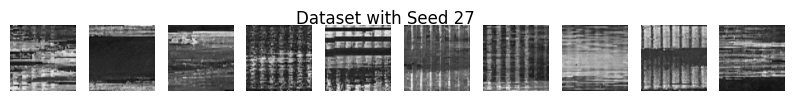

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:31, 95.31s/it]

 29%|██▊       | 2/7 [03:10<07:56, 95.31s/it]

 43%|████▎     | 3/7 [04:45<06:21, 95.30s/it]

 57%|█████▋    | 4/7 [06:21<04:45, 95.30s/it]

 71%|███████▏  | 5/7 [07:56<03:10, 95.30s/it]

 86%|████████▌ | 6/7 [09:31<01:35, 95.30s/it]

100%|██████████| 7/7 [11:00<00:00, 94.36s/it]


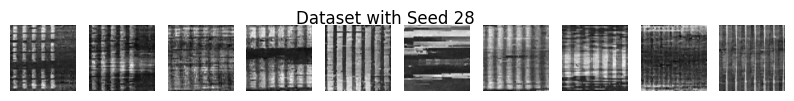

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:31, 95.29s/it]

 29%|██▊       | 2/7 [03:10<07:56, 95.30s/it]

 43%|████▎     | 3/7 [04:45<06:21, 95.30s/it]

 57%|█████▋    | 4/7 [06:21<04:45, 95.29s/it]

 71%|███████▏  | 5/7 [07:56<03:10, 95.29s/it]

 86%|████████▌ | 6/7 [09:31<01:35, 95.29s/it]

100%|██████████| 7/7 [11:00<00:00, 94.36s/it]


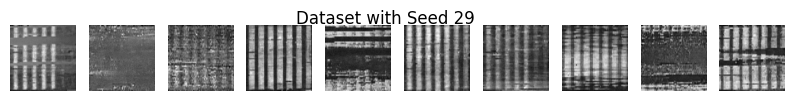

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:31, 95.29s/it]

 29%|██▊       | 2/7 [03:10<07:56, 95.30s/it]

 43%|████▎     | 3/7 [04:45<06:21, 95.29s/it]

 57%|█████▋    | 4/7 [06:21<04:45, 95.30s/it]

 71%|███████▏  | 5/7 [07:56<03:10, 95.30s/it]

 86%|████████▌ | 6/7 [09:31<01:35, 95.31s/it]

100%|██████████| 7/7 [11:00<00:00, 94.36s/it]


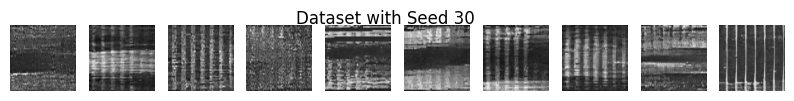

In [ ]:
# Create a directory to save the generated image datasets
model_path = "./generation/" + model_name + "_168x168"
if not os.path.exists(model_path):
    os.makedirs(model_path)

labels_to_condition = y_test  # Assuming you've already prepared y_test

chunk_size = 130
num_chunks = (len(labels_to_condition) + chunk_size - 1) // chunk_size  # This computes the ceil of division

# Loop to create 30 different datasets
for i in range(23, 31):
    np.random.seed(i)  # Set the random seed

    all_generated_images = []  # List to store all generated images across chunks

    for idx in tqdm(range(num_chunks)):
        start_idx = idx * chunk_size
        end_idx = min((idx + 1) * chunk_size, len(labels_to_condition))
        current_chunk = labels_to_condition[start_idx:end_idx]

        np.random.seed(idx)  # Set the random seed for each chunk

        ground_truth = torch.tensor(X_test[start_idx:end_idx]).float().to(device)
        ctx = torch.tensor(current_chunk).float().to(device)
        input_tensor, _ = sample_ddpm_context(ctx.shape[0], ctx)

        # Check if the tensor is on GPU
        if input_tensor.is_cuda:
            input_tensor = input_tensor.cpu()

        # Convert to NumPy array
        generated_images = input_tensor.numpy()
        generated_images = np.transpose(generated_images, (0, 2, 3, 1))

        # Rescale image pixel values to [0, 1]
        generated_images = 0.5 * generated_images + 0.5
        #display_images(generated_images, title=f"Dataset with Seed {i}")

        all_generated_images.append(generated_images)  # Add the generated images of this chunk to the list

    # Concatenate all the generated images
    all_generated_images = np.concatenate(all_generated_images, axis=0)

    # Show the first 10 images of the generated dataset
    display_images(all_generated_images, title=f"Dataset with Seed {i}")

    # Save the dataset
    np.save(os.path.join(model_path, f"generated_images_seed_{i}.npy"), all_generated_images)

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:42<10:17, 102.88s/it]

 29%|██▊       | 2/7 [03:18<08:13, 98.66s/it] 

 43%|████▎     | 3/7 [04:54<06:28, 97.22s/it]

 57%|█████▋    | 4/7 [06:29<04:49, 96.54s/it]

 71%|███████▏  | 5/7 [08:05<03:12, 96.16s/it]

 86%|████████▌ | 6/7 [09:40<01:35, 95.94s/it]

100%|██████████| 7/7 [11:09<00:00, 95.62s/it]


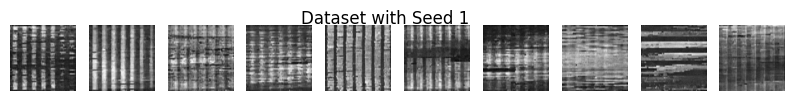

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:32, 95.49s/it]

 29%|██▊       | 2/7 [03:10<07:57, 95.49s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.49s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.50s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.49s/it]

100%|██████████| 7/7 [11:01<00:00, 94.53s/it]


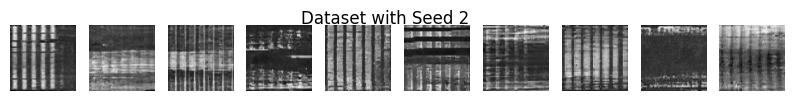

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.53s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.51s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.50s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.50s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.49s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.49s/it]

100%|██████████| 7/7 [11:01<00:00, 94.53s/it]


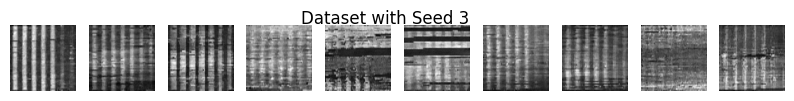

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.51s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.50s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.50s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.50s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.50s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.50s/it]

100%|██████████| 7/7 [11:01<00:00, 94.54s/it]


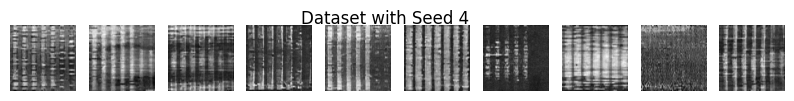

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.52s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.50s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.48s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.49s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.49s/it]

100%|██████████| 7/7 [11:01<00:00, 94.53s/it]


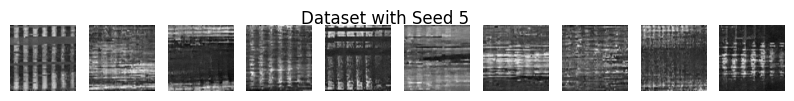

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.51s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.50s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.50s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.49s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.49s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.49s/it]

100%|██████████| 7/7 [11:01<00:00, 94.53s/it]


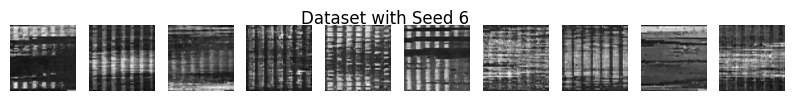

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.53s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.51s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.50s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.50s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.50s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.50s/it]

100%|██████████| 7/7 [11:01<00:00, 94.54s/it]


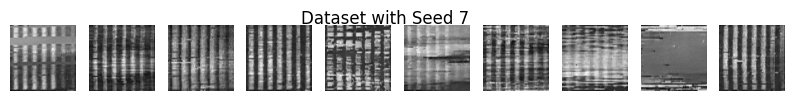

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.51s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.52s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.52s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.52s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.52s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.52s/it]

100%|██████████| 7/7 [11:01<00:00, 94.56s/it]


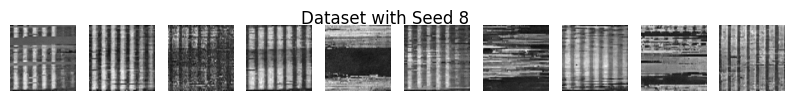

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:32, 95.50s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.51s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.51s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.51s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.52s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.52s/it]

100%|██████████| 7/7 [11:01<00:00, 94.56s/it]


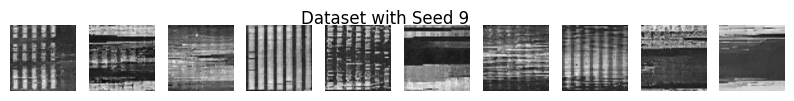

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:32, 95.49s/it]

 29%|██▊       | 2/7 [03:10<07:57, 95.49s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.48s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.48s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.48s/it]

100%|██████████| 7/7 [11:01<00:00, 94.53s/it]


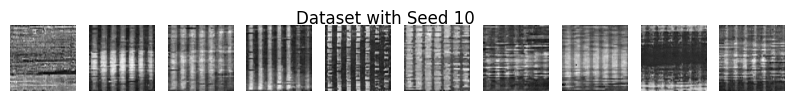

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.50s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.51s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.50s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.52s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.50s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.50s/it]

100%|██████████| 7/7 [11:01<00:00, 94.54s/it]


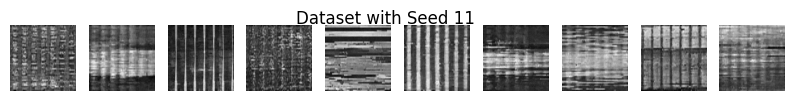

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:32, 95.49s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.51s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.52s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.53s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.53s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.51s/it]

100%|██████████| 7/7 [11:01<00:00, 94.55s/it]


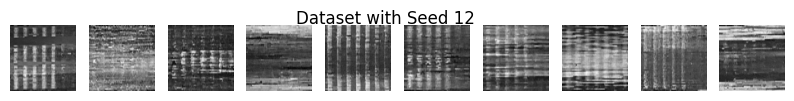

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.55s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.52s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.50s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.52s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.51s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.50s/it]

100%|██████████| 7/7 [11:01<00:00, 94.55s/it]


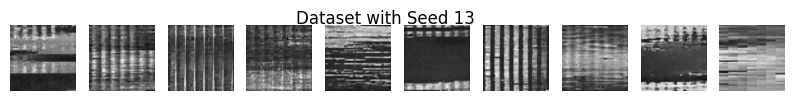

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.54s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.54s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.52s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.52s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.52s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.53s/it]

100%|██████████| 7/7 [11:01<00:00, 94.57s/it]


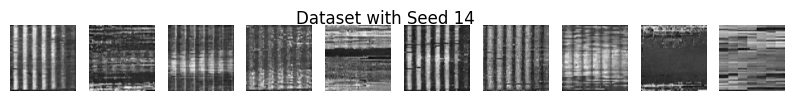

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.53s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.51s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.51s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.50s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.50s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.51s/it]

100%|██████████| 7/7 [11:01<00:00, 94.55s/it]


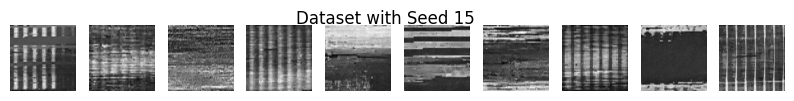

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.53s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.53s/it]

 43%|████▎     | 3/7 [04:46<06:22, 95.53s/it]

 57%|█████▋    | 4/7 [06:22<04:46, 95.53s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.53s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.53s/it]

100%|██████████| 7/7 [11:01<00:00, 94.57s/it]


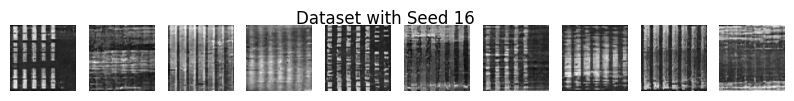

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.52s/it]

 29%|██▊       | 2/7 [03:10<07:57, 95.50s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.50s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.49s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.51s/it]

100%|██████████| 7/7 [11:01<00:00, 94.55s/it]


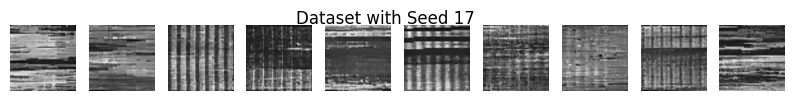

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.51s/it]

 29%|██▊       | 2/7 [03:10<07:57, 95.49s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.48s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.48s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.48s/it]

100%|██████████| 7/7 [11:01<00:00, 94.52s/it]


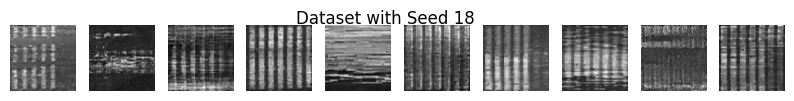

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.51s/it]

 29%|██▊       | 2/7 [03:10<07:57, 95.49s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.49s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.48s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.48s/it]

100%|██████████| 7/7 [11:01<00:00, 94.53s/it]


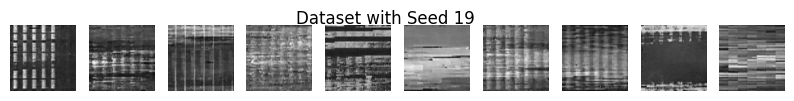

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:32, 95.48s/it]

 29%|██▊       | 2/7 [03:10<07:57, 95.49s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.50s/it]

 71%|███████▏  | 5/7 [07:57<03:11, 95.51s/it]

 86%|████████▌ | 6/7 [09:33<01:35, 95.51s/it]

100%|██████████| 7/7 [11:01<00:00, 94.54s/it]


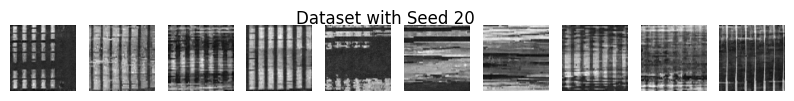

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:33, 95.52s/it]

 29%|██▊       | 2/7 [03:11<07:57, 95.50s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.49s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.49s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.49s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.49s/it]

100%|██████████| 7/7 [11:01<00:00, 94.53s/it]


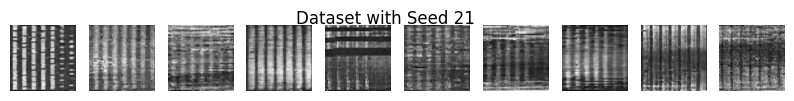

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:35<09:32, 95.46s/it]

 29%|██▊       | 2/7 [03:10<07:57, 95.46s/it]

 43%|████▎     | 3/7 [04:46<06:21, 95.47s/it]

 57%|█████▋    | 4/7 [06:21<04:46, 95.48s/it]

 71%|███████▏  | 5/7 [07:57<03:10, 95.48s/it]

 86%|████████▌ | 6/7 [09:32<01:35, 95.48s/it]

100%|██████████| 7/7 [11:01<00:00, 94.52s/it]


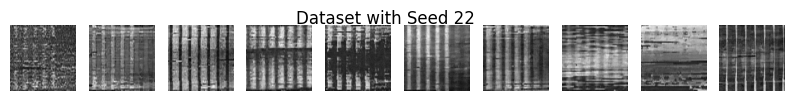

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-139bc1623185>", line 49, in <cell line: 12>
    np.save(os.path.join(model_path, f"generated_images_seed_{i}.npy"), all_generated_images)
  File "<__array_function__ internals>", line 180, in save
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 518, in save
    file_ctx = open(file, "wb")
OSError: [Errno 107] Transport endpoint is not connected: './generation/diffusion_model_168x168/generated_images_seed_22.npy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handl

In [ ]:
# Create a directory to save the generated image datasets
model_path = "./generation/" + model_name + "_168x168"
if not os.path.exists(model_path):
    os.makedirs(model_path)

labels_to_condition = y_test  # Assuming you've already prepared y_test

chunk_size = 130
num_chunks = (len(labels_to_condition) + chunk_size - 1) // chunk_size  # This computes the ceil of division

# Loop to create 30 different datasets
for i in range(1, 31):
    np.random.seed(i)  # Set the random seed

    all_generated_images = []  # List to store all generated images across chunks

    for idx in tqdm(range(num_chunks)):
        start_idx = idx * chunk_size
        end_idx = min((idx + 1) * chunk_size, len(labels_to_condition))
        current_chunk = labels_to_condition[start_idx:end_idx]

        np.random.seed(idx)  # Set the random seed for each chunk

        ground_truth = torch.tensor(X_test[start_idx:end_idx]).float().to(device)
        ctx = torch.tensor(current_chunk).float().to(device)
        input_tensor, _ = sample_ddpm_context(ctx.shape[0], ctx)

        # Check if the tensor is on GPU
        if input_tensor.is_cuda:
            input_tensor = input_tensor.cpu()

        # Convert to NumPy array
        generated_images = input_tensor.numpy()
        generated_images = np.transpose(generated_images, (0, 2, 3, 1))

        # Rescale image pixel values to [0, 1]
        generated_images = 0.5 * generated_images + 0.5
        #display_images(generated_images, title=f"Dataset with Seed {i}")

        all_generated_images.append(generated_images)  # Add the generated images of this chunk to the list

    # Concatenate all the generated images
    all_generated_images = np.concatenate(all_generated_images, axis=0)

    # Show the first 10 images of the generated dataset
    display_images(all_generated_images, title=f"Dataset with Seed {i}")

    # Save the dataset
    np.save(os.path.join(model_path, f"generated_images_seed_{i}.npy"), all_generated_images)